In [99]:
import pandas as pd
import numpy as np

# For data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# For encoding categorical variables
import category_encoders as ce

# For handling class imbalance
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# For model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_curve

# Additional libraries for changes
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve, RandomizedSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# For visualization
import matplotlib.pyplot as plt


### 1. Load the Dataset

In [100]:
# Load the dataset
df = pd.read_csv('datasets/diabetic_data.csv')

### 2. Handle Missing Values
Based on the provided missing value percentages:

- Drop weight column due to 96.86% missing data.
- Impute race missing values (2.23%) with the mode.
- Impute payer_code (39.56%) and medical_specialty (49.08%) missing values with 'Missing'.
- Impute diag_1, diag_2, diag_3 missing values with the mode.

#### 2.1 Add the SES Index Using the economic datasets where SES index is calculated as a weighted average of socioeconomic indicators

In [101]:
# Hardcoded socioeconomic approximations
average_income_1999_2008 = {
    'All Races': 36740,
    'White Alone': 38690,
    'Black Alone': 24352,
    'Asian Alone': 40438,
    'Hispanic (any race)': 20969,
    'Other': 30000  # Approx fallback
}

s1902_per_capita_income = {
    'All Races': 27334,
    'White Alone': 30154,
    'Black Alone': 18257,
    'Asian Alone': 30021,
    'Hispanic (any race)': 15638,
    'Other': 14927
}

s2701_uninsured_rate = {
    'All Races': 14.90,
    'White Alone': 13.10,
    'Black Alone': 17.50,
    'Asian Alone': 14.80,
    'Hispanic (any race)': 30.10,
    'Other': 33.50
}

b19037_median_income_age = {
    'Under 25': 30000,
    '25-44': 60000,
    '45-64': 60000,
    '65+': 30000
}

race_map = {
    'Caucasian': 'White Alone',
    'AfricanAmerican': 'Black Alone',
    'Asian': 'Asian Alone',
    'Hispanic': 'Hispanic (any race)',
    'Other': 'Other',
    '?': 'All Races'
}

def map_age_to_bracket(age_str):
    age_low = int(age_str.strip('[]()').split('-')[0])
    if age_low < 25:
        return 'Under 25'
    elif 25 <= age_low <= 44:
        return '25-44'
    elif 45 <= age_low <= 64:
        return '45-64'
    else:
        return '65+'

df['age_bracket'] = df['age'].apply(map_age_to_bracket)

def get_h15_income(race):
    return average_income_1999_2008.get(race_map.get(race, 'All Races'), 36740)

def get_s1902_income(race):
    return s1902_per_capita_income.get(race_map.get(race, 'All Races'), 27334)

def get_s2701_uninsured(race):
    return s2701_uninsured_rate.get(race_map.get(race, 'All Races'), 14.90)

def get_b19037_median_income(age_bracket):
    return b19037_median_income_age.get(age_bracket, 30000)

payer_income_map = {
    'MC': 'Medicare',
    'MD': 'Medicaid',
    'BC': 'PrivateInsurance_HighIncome',
    '?': 'UnknownPayer'
}

def get_payer_approx_income(payer_code, default_income):
    category = payer_income_map.get(payer_code, 'UnknownPayer')
    if category == 'Medicaid':
        return default_income * 0.8
    elif category == 'PrivateInsurance_HighIncome':
        return default_income * 1.2
    else:
        return default_income

df['race_income_h15'] = df['race'].apply(get_h15_income)
df['race_per_capita_income_s1902'] = df['race'].apply(get_s1902_income)
df['uninsured_rate_s2701'] = df['race'].apply(get_s2701_uninsured)
df['median_income_by_age_b19037'] = df['age_bracket'].apply(get_b19037_median_income)
df['payer_inferred_income'] = df.apply(lambda x: get_payer_approx_income(x['payer_code'], x['race_income_h15']), axis=1)

# Composite SES Index
df['SES_index'] = ((df['race_income_h15']/10000) 
                   + (df['race_per_capita_income_s1902']/10000) 
                   + (df['median_income_by_age_b19037']/10000) 
                   - (df['uninsured_rate_s2701']/10))


#### 2.2 Data Cleaning

In [102]:
# Drop 'weight' column
df.drop('weight', axis=1, inplace=True)

# Replace '?' with NaN for easier handling
df.replace('?', np.nan, inplace=True)

# Impute 'race' missing values with mode
df['race'].fillna(df['race'].mode()[0], inplace=True)

# Impute 'payer_code' and 'medical_specialty' missing values with 'Missing'
df['payer_code'].fillna('Missing', inplace=True)
df['medical_specialty'].fillna('Missing', inplace=True)

# Impute 'diag_1', 'diag_2', 'diag_3' missing values with 'Missing'
df['diag_1'].fillna('Missing', inplace=True)
df['diag_2'].fillna('Missing', inplace=True)
df['diag_3'].fillna('Missing', inplace=True)

# Drop 'encounter_id' and 'patient_nbr'
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

C:\Users\adith\AppData\Local\Temp\ipykernel_20708\3107007933.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna(df['race'].mode()[0], inplace=True)
C:\Users\adith\AppData\Local\Temp\ipykernel_20708\3107007933.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

### 3. Map ID Columns to Categories
Map admission_type_id, discharge_disposition_id, and admission_source_id to their corresponding categorical labels.

In [103]:
# Admission Type ID mapping
admission_type_mapping = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}

df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping)
df['admission_type_id'].fillna('Missing', inplace=True)

# Discharge Disposition ID mapping
discharge_disposition_mapping = {
    1: 'Discharged to home',
    2: 'Discharged/transferred to another short-term hospital',
    3: 'Discharged/transferred to SNF',
    4: 'Discharged/transferred to ICF',
    5: 'Discharged/transferred to another type of inpatient care institution',
    6: 'Discharged/transferred to home with home health service',
    7: 'Left AMA',
    8: 'Discharged/transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'Neonate discharged to another hospital for neonatal aftercare',
    11: 'Expired',
    12: 'Still patient or expected to return for outpatient services',
    13: 'Hospice/home',
    14: 'Hospice/medical facility',
    15: 'Discharged/transferred within this institution to Medicare-approved swing bed',
    16: 'Discharged/transferred/referred to another institution for outpatient services',
    17: 'Discharged/transferred/referred to this institution for outpatient services',
    18: 'NULL',
    19: 'Expired at home (Medicaid only, hospice)',
    20: 'Expired in a medical facility (Medicaid only, hospice)',
    21: 'Expired, place unknown (Medicaid only, hospice)',
    22: 'Discharged/transferred to another rehab facility including rehab units of a hospital',
    23: 'Discharged/transferred to a long-term care hospital',
    24: 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare',
    25: 'Not Mapped',
    26: 'Unknown/Invalid',
    27: 'Discharged/transferred to a federal health care facility',
    28: 'Discharged/transferred/referred to a psychiatric hospital or psychiatric distinct part unit of a hospital',
    29: 'Discharged/transferred to a Critical Access Hospital (CAH)',
    30: 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
}

df['discharge_disposition_id'] = df['discharge_disposition_id'].map(discharge_disposition_mapping)
df['discharge_disposition_id'].fillna('Missing', inplace=True)

# Admission Source ID mapping
admission_source_mapping = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from a hospital',
    5: 'Transfer from a Skilled Nursing Facility',
    6: 'Transfer from another health care facility',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from critical access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    17: 'NULL',
    18: 'Transfer From Another Home Health Agency',
    19: 'Readmission to Same Home Health Agency',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer from hospital inpatient/same facility resulting in a separate claim',
    23: 'Born inside this hospital',
    24: 'Born outside this hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
}

df['admission_source_id'] = df['admission_source_id'].map(admission_source_mapping)
df['admission_source_id'].fillna('Missing', inplace=True)


C:\Users\adith\AppData\Local\Temp\ipykernel_20708\1796466741.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['admission_type_id'].fillna('Missing', inplace=True)
C:\Users\adith\AppData\Local\Temp\ipykernel_20708\1796466741.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

### 4. Encoding Categorical Variables

#### 4.1 Ordinal Encoding for age

In [104]:
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

df['age'] = df['age'].map(age_mapping)

#### 4.2 Encoding Medication Features
Map medication features to numerical values:

- 'No' = 0
- 'Steady' = 1
- 'Up' = 2
- 'Down' = -1

In [105]:
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                      'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                      'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                      'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                      'metformin-pioglitazone']

medication_mapping = {
    'No': 0,
    'Down': -1,
    'Steady': 1,
    'Up': 2
}

# Remove medications with only one unique value (if any)
unique_values = df[medication_columns].nunique()
meds_to_keep = unique_values[unique_values > 1].index.tolist()
medication_columns = meds_to_keep

for col in medication_columns:
    df[col] = df[col].map(medication_mapping)

In [106]:
# Step 1: Load and preprocess the ICD-9 mapping dataset
diagnosis_data_1 = pd.read_csv('datasets/V27LONG_SHORT_DX_110909.csv', encoding='latin1')
diagnosis_data_2 = pd.read_csv('datasets/V27LONG_SHORT_DX_110909u021012.csv', encoding='latin1')

# Combine both datasets
icd9_mapping = pd.concat([diagnosis_data_1, diagnosis_data_2]).drop_duplicates()

# Ensure consistent column names
icd9_mapping.columns = ['diagnosis_code', 'long_description', 'short_description']

# Add hierarchical level mapping
icd9_mapping['primary_category'] = icd9_mapping['diagnosis_code'].str[:3]  # First 3 digits
icd9_mapping['specific_condition'] = icd9_mapping['long_description']  # Full description

# Handle duplicates in the diagnosis code
icd9_mapping = icd9_mapping.drop_duplicates(subset=['diagnosis_code'])

# Create a dictionary for fast lookup
icd9_dict = icd9_mapping.set_index('diagnosis_code')[['primary_category', 'specific_condition']].to_dict('index')


# Step 2: Define the mapping function
def map_icd9_hierarchical(code):
    """
    Maps an ICD-9 code to its hierarchical components.
    If the code is not found, it assigns 'Unknown'.
    """
    return icd9_dict.get(code, {'primary_category': 'Missing', 'specific_condition': 'Missing'})

# Step 3: Encode all components using LabelEncoder
def apply_hierarchical_mapping(df, diag_col, encoders):
    """
    Splits and encodes diagnosis columns into multiple subcomponents.
    """
    # Map the diagnosis codes to hierarchical levels
    mapped = df[diag_col].apply(map_icd9_hierarchical).apply(pd.Series)
    
    # Encode each component using LabelEncoder
    for component in ['primary_category', 'specific_condition']:
        mapped[component] = encoders[component].fit_transform(mapped[component])
    
    # Add the encoded components as new columns
    for component in ['primary_category', 'specific_condition']:
        df[f'{component}_{diag_col}'] = mapped[component]
    
    return df

# Step 4: Apply the function to the diagnosis columns
# Initialize LabelEncoders for all components
encoders = {
    'primary_category': LabelEncoder(),
    'specific_condition': LabelEncoder(),
}

# Apply hierarchical mapping to each diagnosis column
for diag in ['diag_1', 'diag_2', 'diag_3']:
    df = apply_hierarchical_mapping(df, diag, encoders)

# Step 5: Drop the original diagnosis columns to keep only hierarchical components
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

#### 4.3 Encoding Payer Code

In [107]:
payer_mapping = {
    'MC': 'Public Insurance',   # Medicare
    'MD': 'Public Insurance',   # Medicaid
    'HM': 'Private Insurance',  # HMO
    'BC': 'Private Insurance',  # Blue Cross
    'SP': 'Self-Pay',           # Self-Pay
    'UN': 'Uninsured',          # Uninsured
    'CP': 'Private Insurance',  # Commercial
    'SI': 'Public Insurance',   # State Insurance
    'DM': 'Other Insurance',    # Department of Defense
    'CM': 'Other Insurance',    # Champus
    'CH': 'Other Insurance',    # Champva
    'PO': 'Private Insurance',  # Other Private Insurance
    'WC': 'Other Insurance',    # Workers' Compensation
    'OT': 'Other Insurance',    # Other
    'OG': 'Public Insurance',   # Other Government
    'MP': 'Public Insurance',   # Medicare Pending
    'FR': 'Other Insurance',    # Foreign Government
    'Missing': 'Missing'              # Missing/Unknown
}

# Apply the mapping
df['payer_group'] = df['payer_code'].map(payer_mapping)

#### 4.4 Encoding Remaining Categorical Variables
Identify all categorical columns.

In [108]:
# Encode target variable first to ensure it's numeric for target encoding
# Combine '>30' and '<30' into 'YES', 'NO' remains the same
df['readmitted'] = df['readmitted'].replace({'>30': 'YES', '<30': 'YES', 'NO': 'NO'})

# Encode target variable
df['readmitted'] = df['readmitted'].map({'NO': 0, 'YES': 1})

# Separate features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Identify high cardinality categorical columns
high_card_cols = ['medical_specialty', 'primary_category_diag_1', 'specific_condition_diag_1',
    'primary_category_diag_2', 'specific_condition_diag_2',
    'primary_category_diag_3', 'specific_condition_diag_3']

# Remaining categorical columns, including mapped diagnoses, to be one-hot encoded
remaining_categorical = list(set(categorical_columns) - set(high_card_cols))

# Perform train-test split before encoding to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42)

# One-Hot Encode remaining categorical features after split
X_train = pd.get_dummies(X_train, columns=remaining_categorical, drop_first=False)
X_test = pd.get_dummies(X_test, columns=remaining_categorical, drop_first=False)

# Align train and test sets (handle any missing dummy columns in test set)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Initialize Target Encoder for 'medical_specialty'
target_encoder = ce.TargetEncoder(cols=high_card_cols)

# Fit the encoder on training data
X_train[high_card_cols] = target_encoder.fit_transform(X_train[high_card_cols], y_train)

# Transform the test data
X_test[high_card_cols] = target_encoder.transform(X_test[high_card_cols])



C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:308: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[column].fillna(-1, inplace=True)
C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:308: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment 

# 5. Exploratory Data Analysis

*Analysis: Compare readmission rates by race categories mapped to SES features.*

Mean readmission rates by race:
              race  readmitted
0  AfricanAmerican    0.457522
1            Asian    0.352574
2        Caucasian    0.464987
3         Hispanic    0.419244
4            Other    0.392430


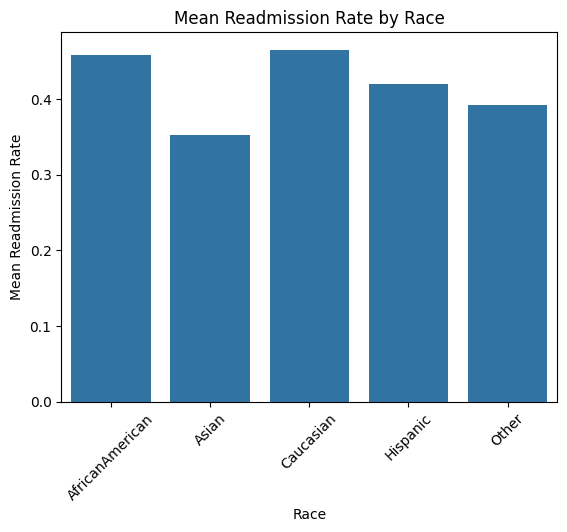

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analysis: Compare readmission rates by race categories mapped to SES features.
race_groups = df.groupby('race')['readmitted'].mean().reset_index()

print("Mean readmission rates by race:")
print(race_groups)

# Visualize disparities
sns.barplot(x='race', y='readmitted', data=race_groups)
plt.title("Mean Readmission Rate by Race")
plt.xlabel("Race")
plt.ylabel("Mean Readmission Rate")
plt.xticks(rotation=45)
plt.show()

SES_index distribution by age_bracket:
               count       mean       std     min     25%      50%      75%  \
age_bracket                                                                   
25-44        13460.0  10.380629  1.629129  6.6507  8.5109  11.5744  11.5744   
45-64        39739.0  10.717084  1.474149  6.6507  8.5109  11.5744  11.5744   
65+          46058.0   8.055057  1.207893  3.6507  8.5744   8.5744   8.5744   
Under 25      2509.0   7.380522  1.618048  3.6507  5.5109   8.5744   8.5744   

                 max  
age_bracket           
25-44        11.5744  
45-64        11.5744  
65+           8.5744  
Under 25      8.5744  


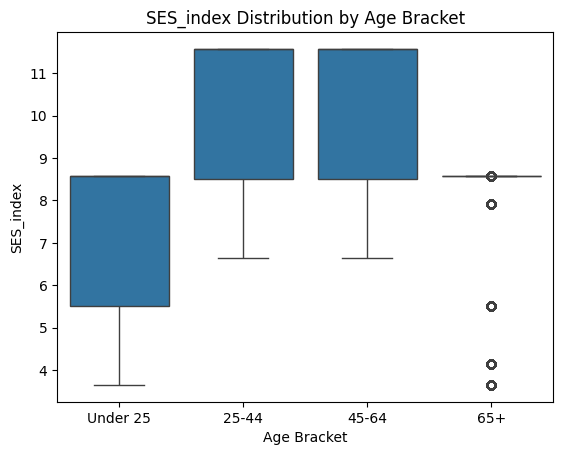

In [110]:
# Analysis: Examine the distribution of SES_index by age bracket
age_ses = df.groupby('age_bracket')['SES_index'].describe()

print("SES_index distribution by age_bracket:")
print(age_ses)

# Visualize the distribution
sns.boxplot(x='age_bracket', y='SES_index', data=df)
plt.title("SES_index Distribution by Age Bracket")
plt.xlabel("Age Bracket")
plt.ylabel("SES_index")
plt.show()


SES_index distribution by readmission status:
              count      mean       std     min     25%     50%      75%  \
readmitted                                                                 
0           54864.0  9.395934  1.927965  3.6507  8.5744  8.5744  11.5744   
1           46902.0  9.373343  1.888684  3.6507  8.5744  8.5744  11.5744   

                max  
readmitted           
0           11.5744  
1           11.5744  


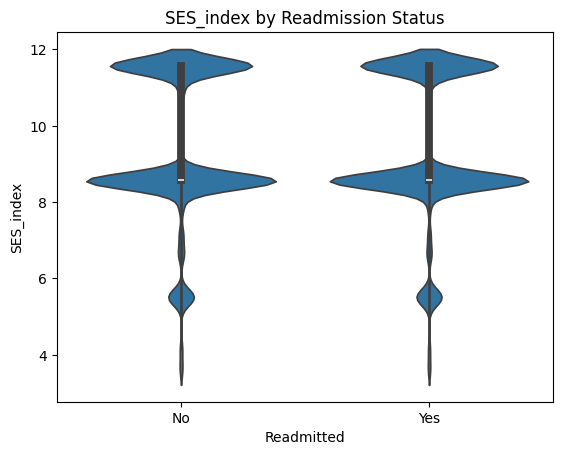

In [111]:
# Analysis: Focus on a subgroup. For instance, patients readmitted 
# and how SES_index differs for those who are readmitted vs not.

subgroup_stats = df.groupby('readmitted')['SES_index'].describe()
print("SES_index distribution by readmission status:")
print(subgroup_stats)

# Compare distributions
sns.violinplot(x='readmitted', y='SES_index', data=df)
plt.title("SES_index by Readmission Status")
plt.xlabel("Readmitted")
plt.ylabel("SES_index")
plt.xticks([0,1], ['No','Yes'])
plt.show()


Mean readmission rate by SES cluster:
   SES_cluster  readmitted
0            0    0.449257
1            1    0.453018
2            2    0.477626


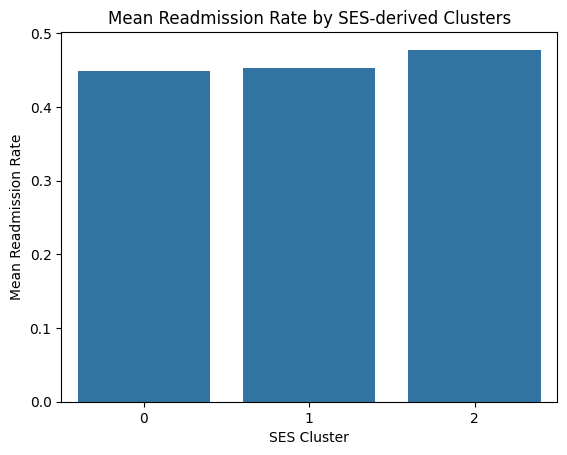

In [112]:
from sklearn.cluster import KMeans

# Analysis: Cluster patients based on SES-related features 
# and see if readmission differs among clusters.
features_for_clustering = df[['race_income_h15', 'race_per_capita_income_s1902', 'uninsured_rate_s2701', 'median_income_by_age_b19037', 'SES_index']]
features_array = features_for_clustering.values

kmeans = KMeans(n_clusters=3, random_state=42)
df['SES_cluster'] = kmeans.fit_predict(features_array)

cluster_readmission = df.groupby('SES_cluster')['readmitted'].mean().reset_index()
print("Mean readmission rate by SES cluster:")
print(cluster_readmission)

sns.barplot(x='SES_cluster', y='readmitted', data=cluster_readmission)
plt.title("Mean Readmission Rate by SES-derived Clusters")
plt.xlabel("SES Cluster")
plt.ylabel("Mean Readmission Rate")
plt.show()


In [113]:
# Analysis: Identify which groups (race and age bracket) have the lowest SES_index 
# and highest readmission, to suggest targeted interventions.

grouped = df.groupby(['race','age_bracket']).agg({
    'SES_index': 'mean',
    'readmitted': 'mean'
}).reset_index()

# Find the group with the lowest SES_index and highest readmission
lowest_ses = grouped.iloc[grouped['SES_index'].argmin()]
highest_readmission = grouped.iloc[grouped['readmitted'].argmax()]

print("Group with lowest SES_index:\n", lowest_ses)
print("\nGroup with highest readmission rate:\n", highest_readmission)

# Potentially, if the same or similar groups appear in these statistics,
# policy recommendations can focus on addressing socioeconomic barriers

Group with lowest SES_index:
 race           Hispanic
age_bracket         65+
SES_index        3.6507
readmitted     0.456044
Name: 14, dtype: object

Group with highest readmission rate:
 race           Caucasian
age_bracket          65+
SES_index       8.556344
readmitted      0.480531
Name: 10, dtype: object


**Inferences from the Analysis:**

1. **Readmission Rates by Race**:  
   AfricanAmerican and Caucasian patients show the highest mean readmission rates, while Asian patients have the lowest. Hispanic and Other categories fall in between. This suggests potential disparities in outcomes across racial groups. While we don’t know the underlying causes, it indicates certain racial groups may be at greater risk of readmission and could benefit from targeted interventions or more intensive post-discharge support.

2. **SES Index Distribution by Age Bracket**:  
   Patients under 25 and those 65+ have lower composite SES scores than the middle-aged groups (25–44 and 45–64). The younger (under 25) and older (65+) groups appear socioeconomically disadvantaged according to our SES proxy. This might reflect less stable income, less private insurance coverage, or other structural factors. However, improved SES (as seen in the middle-aged groups) does not necessarily translate directly into lower readmission rates based on previous findings.

3. **SES Index by Readmission Status**:  
   The SES index shows minimal difference between patients who are readmitted and those who are not. Both groups have very similar SES distributions. This suggests that the broad socioeconomic measures used here are not strongly driving differences in readmission at the overall population level. It could mean that clinical, utilization, or other healthcare factors overshadow socioeconomic factors in predicting readmission risk—or that our SES measures are too coarse.

4. **SES-derived Clusters and Readmission**:  
   When clustered into groups based solely on SES features, we observe only small variations in readmission rates among clusters. Although one cluster shows a slightly higher rate, the differences are not pronounced. This again suggests that SES variables alone do not strongly differentiate patient groups in terms of their readmission likelihood.

5. **Identifying Particularly Disadvantaged Groups**:  
   The data indicate that the Hispanic & 65+ group has the lowest SES index. In contrast, the Caucasian & 65+ group shows the highest readmission rate. This finding is intriguing: the group with the lowest SES score (Hispanic older adults) is not the same group with the highest readmission rate (Caucasian older adults). This implies that low SES alone may not be the primary determinant of readmission risk. It may also reflect other factors, such as differences in healthcare utilization patterns, comorbidities, patient engagement, cultural differences in care-seeking behavior, or local healthcare resources.

**Overall Implications**:  
- Socioeconomic proxies from H15, S1902, S2701, and B19037 datasets, as combined here, do not strongly predict readmission on their own.
- Racial and age-based disparities exist in readmission rates, and these differences are partly independent of the composite SES measures.
- Future efforts might focus on more granular data, better linking patient-level information with local socioeconomic conditions, or exploring interactions between SES and clinical factors. While these SES features didn’t improve predictive accuracy, they provide valuable context for understanding and addressing health disparities and guiding targeted interventions or resource allocation.

### 6. Feature Engineering and Scaling:

In [114]:
# 8. Feature Engineering

# Create new feature 'total_prior_visits'
X_train['total_prior_visits'] = (
    X_train['number_outpatient'] + 
    X_train['number_emergency'] + 
    X_train['number_inpatient']
)

X_test['total_prior_visits'] = (
    X_test['number_outpatient'] + 
    X_test['number_emergency'] + 
    X_test['number_inpatient']
)


In [115]:

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform test data
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

### 7. Handling Class Imbalance

In [116]:
#Apply SMOTEek

smote = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### 8. Feature Selection

In [117]:
# Convert resampled data back to DataFrame
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# Initialize Random Forest classifier for feature importance
feat_selector = RandomForestClassifier(n_estimators=150, random_state=42)

# Fit to the resampled training data
feat_selector.fit(X_train_res, y_train_res)

# Select features based on importance threshold (mean importance)
selector = SelectFromModel(feat_selector, prefit=True, threshold='median')

# Get the selected feature names before transforming
selected_features = X_train_res.columns[selector.get_support()]
print(f"Selected Features: {selected_features}")

# Transform the data
X_train_res = selector.transform(X_train_res)
X_test = selector.transform(X_test)


Selected Features: Index(['age', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'race_income_h15',
       'race_per_capita_income_s1902', 'uninsured_rate_s2701',
       'median_income_by_age_b19037', 'payer_inferred_income', 'SES_index',
       'primary_category_diag_1', 'specific_condition_diag_1',
       'primary_category_diag_2', 'specific_condition_diag_2',
       'primary_category_diag_3', 'specific_condition_diag_3',
       'discharge_disposition_id_Discharged to home',
       'discharge_disposition_id_Discharged/transferred to SNF',
       'discharge_disposition_id_Discharged/transferred to another rehab facility including rehab units of a hospital',
       'discharge_disposition_id_Discharged/transferred to another short-t

C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### 9. Model Training

In [118]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scoring='f1_macro', cv=5):
    """
    Train, evaluate, and plot learning curve for a given model.
    
    Parameters:
    - model: The model instance to evaluate (e.g., AdaBoostClassifier, LGBMClassifier, CatBoostClassifier)
    - X_train: Training feature set
    - y_train: Training target labels
    - X_test: Testing feature set
    - y_test: Testing target labels
    - scoring: Scoring metric for the learning curve (default is 'f1_macro')
    - cv: Number of cross-validation splits for learning curve (default is 5)
    """
    # Fit the model on training data
    print(f"Training {model.__class__.__name__}")
    model.fit(X_train, y_train)
    
    
    # Plot learning curve
    print("Generating learning curve...")
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation Score")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring)
    plt.title(f"Learning Curve: {model.__class__.__name__}")
    plt.legend()
    plt.show()

        # Predictions on test set
    y_test_pred = model.predict(X_test)
    print("Evaluation on test set")
    print(classification_report(y_test, y_test_pred))
    
    # Predictions on training set
    y_train_pred = model.predict(X_train)
    print("Evaluation on training set")
    print(classification_report(y_train, y_train_pred))

    # ROC Curve
    print("Generating ROC Curve...")
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model.__class__.__name__}")


In [119]:
# Define models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.02,
        subsample=0.73,
        colsample_bytree=0.73,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=20,
        learning_rate=0.02,
        subsample=0.73,
        colsample_bytree=0.73,
        random_state=42,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=250,
        learning_rate=0.02,
        random_seed=42,
        verbose=0
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2),
        learning_rate=0.02,
        random_state=42
    )
}

Training XGBClassifier


C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [21:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Generating learning curve...


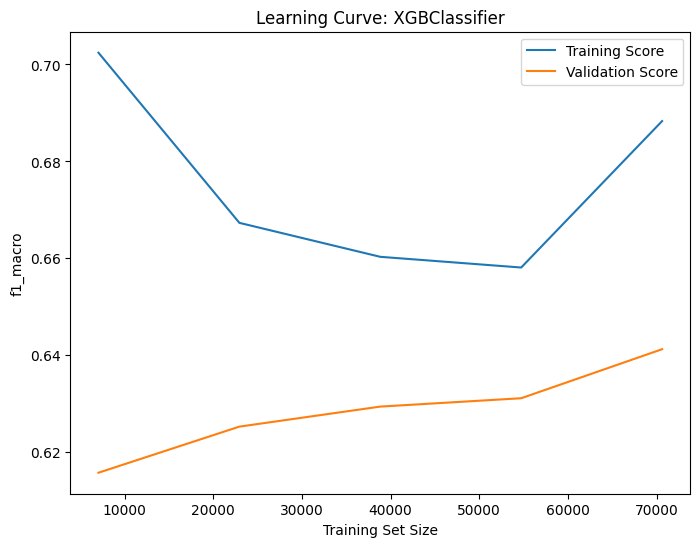

Evaluation on test set
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      5487
           1       0.63      0.56      0.59      4690

    accuracy                           0.64     10177
   macro avg       0.64      0.64      0.64     10177
weighted avg       0.64      0.64      0.64     10177

Evaluation on training set
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     44135
           1       0.71      0.64      0.67     44135

    accuracy                           0.69     88270
   macro avg       0.69      0.69      0.69     88270
weighted avg       0.69      0.69      0.69     88270

Generating ROC Curve...
Training LGBMClassifier
[LightGBM] [Info] Number of positive: 44135, number of negative: 44135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

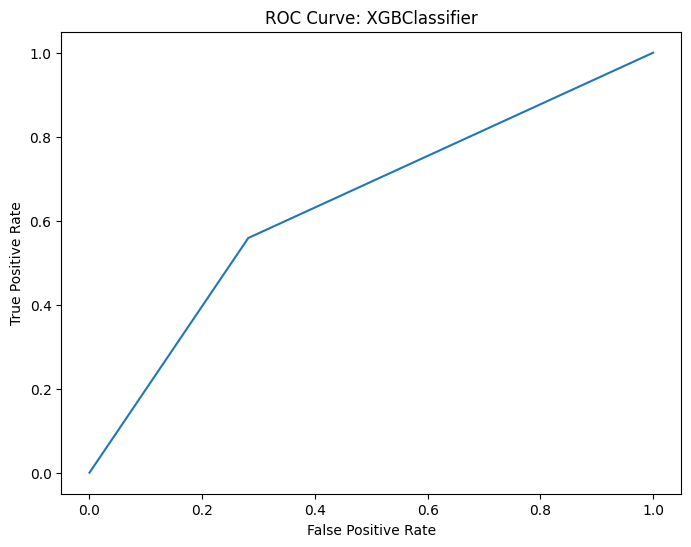

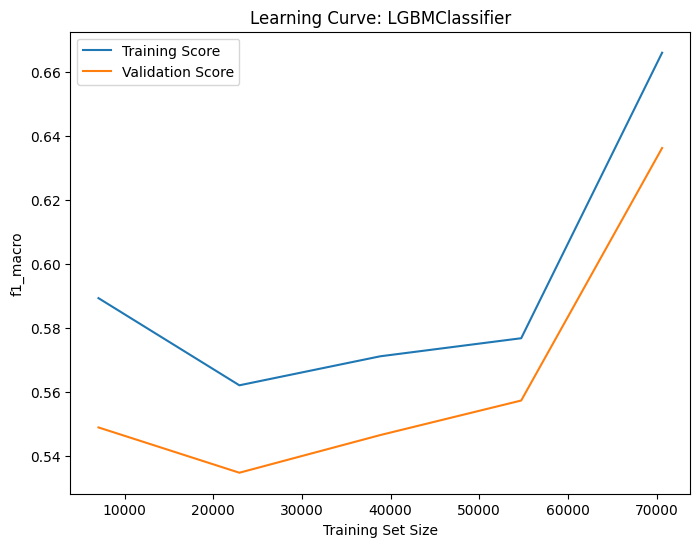

Evaluation on test set
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      5487
           1       0.62      0.54      0.58      4690

    accuracy                           0.64     10177
   macro avg       0.63      0.63      0.63     10177
weighted avg       0.64      0.64      0.63     10177

Evaluation on training set
              precision    recall  f1-score   support

           0       0.65      0.73      0.68     44135
           1       0.69      0.60      0.64     44135

    accuracy                           0.66     88270
   macro avg       0.67      0.66      0.66     88270
weighted avg       0.67      0.66      0.66     88270

Generating ROC Curve...
Training CatBoostClassifier
Generating learning curve...


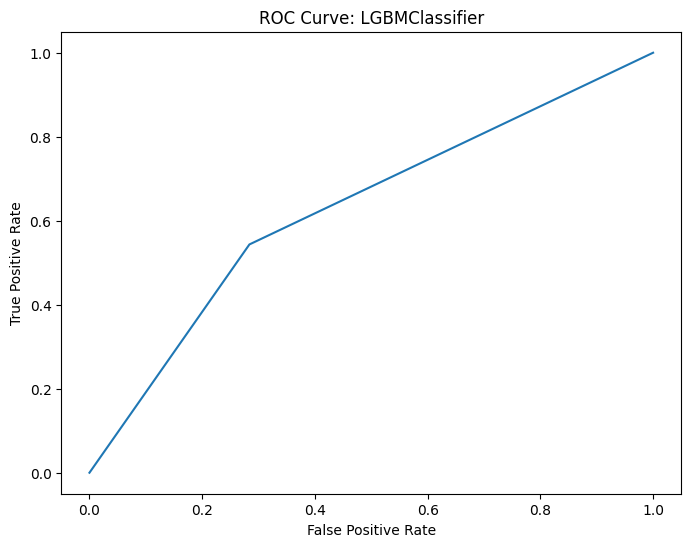

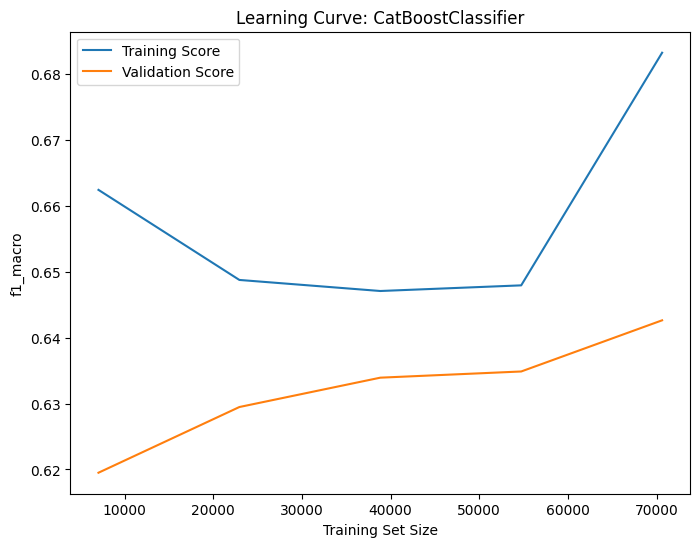

Evaluation on test set
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      5487
           1       0.63      0.53      0.58      4690

    accuracy                           0.64     10177
   macro avg       0.64      0.63      0.63     10177
weighted avg       0.64      0.64      0.64     10177

Evaluation on training set
              precision    recall  f1-score   support

           0       0.66      0.74      0.70     44135
           1       0.71      0.62      0.66     44135

    accuracy                           0.68     88270
   macro avg       0.69      0.68      0.68     88270
weighted avg       0.69      0.68      0.68     88270

Generating ROC Curve...
Training AdaBoostClassifier


C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Generating learning curve...


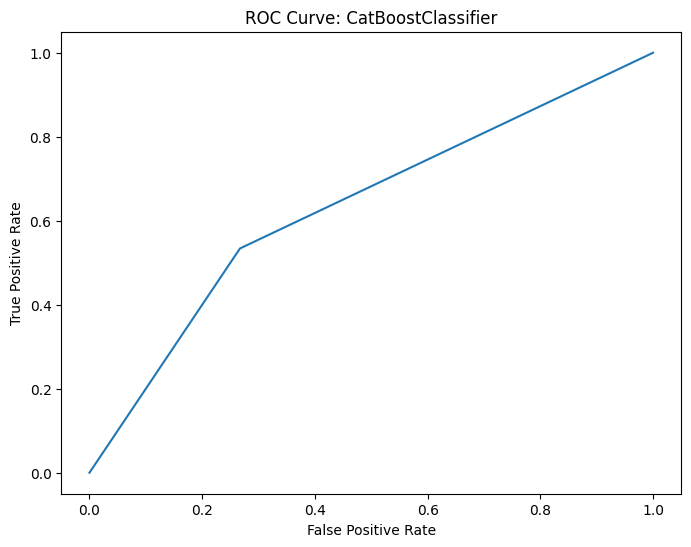

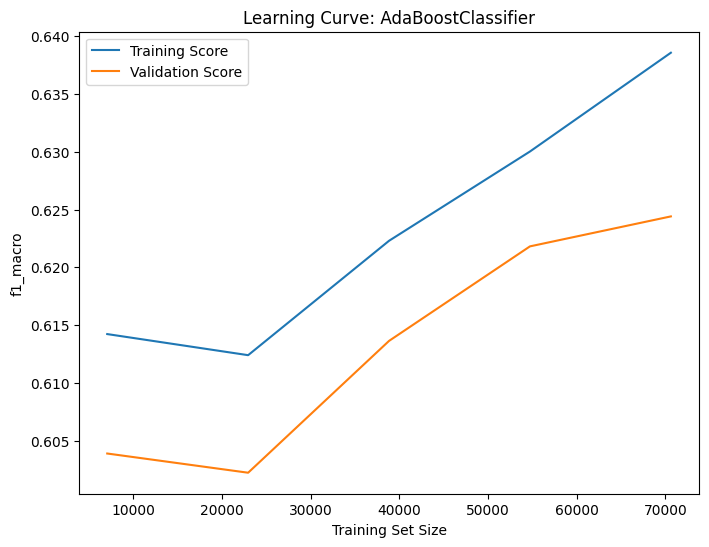

Evaluation on test set
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      5487
           1       0.61      0.54      0.58      4690

    accuracy                           0.63     10177
   macro avg       0.63      0.62      0.62     10177
weighted avg       0.63      0.63      0.63     10177

Evaluation on training set
              precision    recall  f1-score   support

           0       0.62      0.71      0.66     44135
           1       0.66      0.57      0.61     44135

    accuracy                           0.64     88270
   macro avg       0.64      0.64      0.64     88270
weighted avg       0.64      0.64      0.64     88270

Generating ROC Curve...


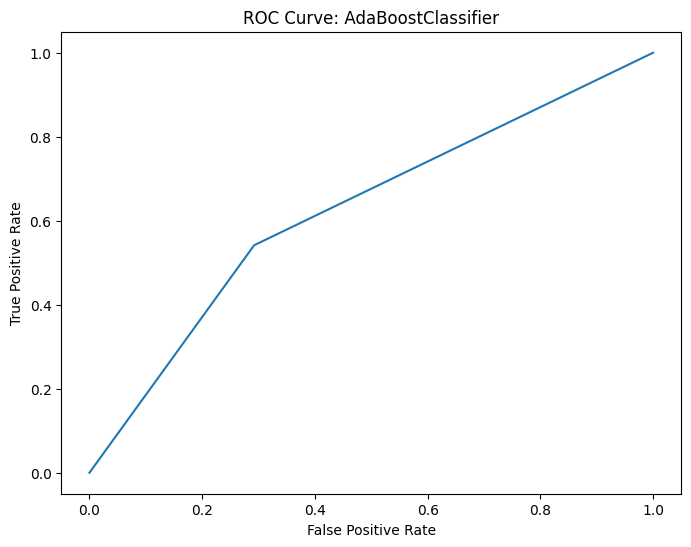

In [120]:
# Train and evaluate models
for model_name, model in models.items():
    evaluate_model(model, X_train_res, y_train_res, X_test, y_test)

In [121]:
X_train[['race_income_h15', 'race_per_capita_income_s1902', 'uninsured_rate_s2701', 'payer_inferred_income']]


# Check their correlation with the target variable
X_train[['race_income_h15', 'race_per_capita_income_s1902', 'uninsured_rate_s2701', 'payer_inferred_income']].corrwith(y_train)


# correlation with the change_Ch column
X_train[['race_income_h15', 'race_per_capita_income_s1902', 'uninsured_rate_s2701', 'payer_inferred_income']].corrwith(X_train['change_Ch'])

race_income_h15                 0.001072
race_per_capita_income_s1902   -0.002856
uninsured_rate_s2701            0.014876
payer_inferred_income          -0.003295
dtype: float64

In [122]:
# Extract feature importances from the Random Forest model
feature_importances = feat_selector.feature_importances_

# Combine selected feature names with their importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use original feature names from X_train
    'Importance': feature_importances
})

# Add a rank column to the sorted feature importance DataFrame
feature_importance_df['Rank'] = feature_importance_df['Importance'].rank(ascending=False, method='min')

# Get the rank of SES_index
ses_index_rank = feature_importance_df.loc[feature_importance_df['Feature'] == 'SES_index', 'Rank'].values

if len(ses_index_rank) > 0:
    print(f"SES_index is ranked: {int(ses_index_rank[0])} out of {len(feature_importance_df)} features.")
else:
    print("SES_index is not found in the feature importance list.")


SES_index is ranked: 24 out of 143 features.
